#Main Analysis Notebook

### After models are trained, used this notebook to extract results

In [2]:
TEST=False #if True, will use TEST data instead.

In [3]:
from mantis_shrimp.utils import get_photopath, my_transform #, central_crop
from mantis_shrimp.augmentation import augment_fn, augment_fn_latefusion
from mantis_shrimp import models
from mantis_shrimp import datasets
from mantis_shrimp import utils


import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import rotate

from einops import rearrange
from astropy.visualization import make_lupton_rgb

from astropy.visualization import PercentileInterval, AsinhStretch
from scipy.ndimage import zoom

from mantis_shrimp.training import train_epoch, val_epoch
from tqdm import tqdm
import pickle
import random
import argparse
import torchvision


import torch.distributed as dist
from torch.utils.data import DataLoader
from collections import deque

In [4]:
WORLD_RANK=0 #!!! Would be suppled from env variables.

In [5]:
def set_random_seeds(random_seed=0):
    torch.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

#I'm going to create a fake argeparse object to track some variables.
class FakeArgParse():
    def __init__(self):
        self.backend = 'nccl'
        self.fusion_type = 'late'
        self.n_classes = 400
        self.z_max = 1.6
        self.n_epochs = 100
        self.use_amp = 'False'
        self.batchsize = 16 #whatever we set here is actually going to be effectively multipled by n_gpus.
        self.galex = True
        self.unwise = True
args = FakeArgParse()

set_random_seeds(random_seed=2202024)

In [6]:
class LateFusionModel(torch.nn.Module):
    def __init__(self,model_galex,model_ps,model_unwise,width:int=2048, num_classes:int= 200, USE_GALEX=True, USE_WISE=True):
        super().__init__()

        self.USE_GALEX = USE_GALEX
        self.USE_WISE = USE_WISE
        
        if self.USE_GALEX:
            self.model_galex = model_galex
        if self.USE_WISE:
            self.model_unwise = model_unwise   
            
        self.model_ps = model_ps

        if self.USE_GALEX and self.USE_WISE:
            self.fc0 = torch.nn.Linear(1532 + 770 + 770 + 2, width)
        elif self.USE_GALEX and not(self.USE_WISE):
            self.fc0 = torch.nn.Linear(1532 + 770 + 4, width)
        elif not(self.USE_GALEX) and self.USE_WISE:
            self.fc0 = torch.nn.Linear(1532 + 770 + 4, width)
        else:
            self.fc0 = torch.nn.Linear(1532+4, width)
        
        self.activation_fn = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(width,num_classes)
        
    def forward(self,x_galex,x_ps,x_unwise,ebv):
        #because I know 10% of the sample of galex are all zeros, I'm going to measure
        #the deviation of the contribution that learns galex from zero. If (x_galex - 0) = 0
        #then x_galex contributes nothing to the model, and the gradients should also be zero 
        #w.r.t. those samples.
        #b_galex = self.get_galex_zero(x_galex.device)

        if self.USE_GALEX:
            x_galex = self.model_galex(x_galex)
        if self.USE_WISE:
            x_unwise = self.model_unwise(x_unwise)
        x_ps = self.model_ps(x_ps)
        
        
        #now combine and do a pseudo average to make sure the features are well scaled.
        if self.USE_GALEX and self.USE_WISE:
            x = torch.concat([x_ps, x_unwise, x_galex],1) #assumes they are all resnet50
        elif self.USE_GALEX and not(self.USE_WISE):
            x = torch.concat([x_ps, x_galex],1)
        elif not(self.USE_GALEX) and self.USE_WISE:
            x = torch.concat([x_ps, x_unwise],1)
        else:
            x = x_ps
        
        x = self.activation_fn(x)
        x = torch.cat([x,ebv],1) #don't want to zero my ebv vector.
        x = self.fc0(x)
        x = self.activation_fn(x)
        x = self.fc1(x)
        
        return x

In [7]:
class ConvModel(torch.nn.Module):
    def __init__(self,Base,num_classes:int=300):
        super().__init__()
        
        #642 if using nano
        #770 if using small
        self.fc0 = torch.nn.Linear(1538,2048)
        self.fc1 = torch.nn.Linear(2048,num_classes)
        self.activation = torch.nn.functional.gelu
        self.Base = Base
    
    def forward(self,x,ebv):
        x = self.Base(x)
        x = torch.cat([x,ebv],axis=1)
        x = self.fc0(x)
        x = self.activation(x)
        x = self.fc1(x)
        return x

In [8]:
N_CLASSES=args.n_classes
LATEFUSION = (args.fusion_type=='late')

In [9]:
### EARLY FUSION
#da92e90b-847d-4b07-98d0-fafea0d14f78model_V1p4epoch_60.pt = CalPIT model + full training early fusion
#0927fb1a-6c82-4b8e-ba42-05c7e6a593f1 #Best early Fusion model
#1a3445e8-7ee4-4595-97f4-a3758bb1bc34 #Ablate both galex and unwise
#8f76a94e-6044-4054-8e33-694d981153ac #Ablate unwise
#cb7857cc-c083-49f9-a6c4-feeaed7683c8 #Ablate galex

### LATE FUSION
#4db7c390-3830-4e27-b092-01c8c3165f29model_V1p4epoch_60.pt #best late fusion
#4a384698-d3b7-4cd5-967d-19f34e2551b8model_V1p4epoch_150.pt #ablate galex late
#08cf1c4c-7df6-450a-b174-da7bab144ebamodel_V1p4epoch_140.pt #ablate unwise late

model_dir = '/rcfs/projects/mantis_shrimp/mantis_shrimp/MODELS/'
best_filename = '4db7c390-3830-4e27-b092-01c8c3165f29model_V1p4epoch_60.pt'
best_filepath = os.path.join(model_dir, best_filename)

In [10]:
args.galex = True
args.unwise = True

In [11]:
import torchvision.models
import timm

if LATEFUSION:
    BaseModel_ps = timm.create_model('hf_hub:mwalmsley/zoobot-encoder-convnext_large', pretrained=True, num_classes=0)
    BaseModel_galex = timm.create_model('hf_hub:mwalmsley/zoobot-encoder-convnext_small', pretrained=True, num_classes=0)
    BaseModel_unwise = timm.create_model('hf_hub:mwalmsley/zoobot-encoder-convnext_small', pretrained=True, num_classes=0)
    
    #PS
    first_layer_bias = BaseModel_ps.stem[0].bias.clone()
    first_layer_weight = BaseModel_ps.stem[0].weight.clone()
    first_layer_weight = (torch.mean(first_layer_weight,dim=1)[:,None,:,:]).repeat(1,5,1,1)
    BaseModel_ps.stem[0] = torch.nn.Conv2d(5,192,kernel_size=(4,4), stride=(4,4))
    BaseModel_ps.stem[0].bias.data = first_layer_bias
    BaseModel_ps.stem[0].weight.data = first_layer_weight
    
    #Galex
    first_layer_bias = BaseModel_galex.stem[0].bias.clone()
    first_layer_weight = BaseModel_galex.stem[0].weight.clone()
    first_layer_weight = (torch.mean(first_layer_weight,dim=1)[:,None,:,:]).repeat(1,2,1,1)
    BaseModel_galex.stem[0] = torch.nn.Conv2d(2,96,kernel_size=(4,4), stride=(4,4))
    BaseModel_galex.stem[0].bias.data = first_layer_bias
    BaseModel_galex.stem[0].weight.data = first_layer_weight
    
    #UnWISE
    first_layer_bias = BaseModel_unwise.stem[0].bias.clone()
    first_layer_weight = BaseModel_unwise.stem[0].weight.clone()
    first_layer_weight = (torch.mean(first_layer_weight,dim=1)[:,None,:,:]).repeat(1,2,1,1)
    BaseModel_unwise.stem[0] = torch.nn.Conv2d(2,96,kernel_size=(4,4), stride=(4,4))
    BaseModel_unwise.stem[0].bias.data = first_layer_bias
    BaseModel_unwise.stem[0].weight.data = first_layer_weight

    model = LateFusionModel(BaseModel_galex,BaseModel_ps,BaseModel_unwise,num_classes=N_CLASSES,USE_GALEX=args.galex,USE_WISE=args.unwise)
else:
    BaseModel = timm.create_model('hf_hub:mwalmsley/zoobot-encoder-convnext_large', pretrained=True, num_classes=0)
    
    first_layer_bias = BaseModel.stem[0].bias.clone()
    first_layer_weight = BaseModel.stem[0].weight.clone()

    num_channels = 5
    if args.galex:
        num_channels+=2
    if args.unwise:
        num_channels+=2
    
    first_layer_weight = (torch.mean(first_layer_weight,dim=1)[:,None,:,:]).repeat(1,num_channels,1,1)
    BaseModel.stem[0] = torch.nn.Conv2d(num_channels,192,kernel_size=(4,4), stride=(4,4))
    BaseModel.stem[0].bias.data = first_layer_bias
    BaseModel.stem[0].weight.data = first_layer_weight
    
    model = ConvModel(BaseModel,num_classes=args.n_classes)

In [12]:
ckpt = torch.load(best_filepath)
old_keys = list(ckpt.keys())
for key in old_keys:
    if 'module.' in key:
        new_key = key.split('module.')[1]
        ckpt[new_key] = ckpt.pop(key)
    else:
        continue

In [13]:
#ckpt['Base.stem.0.weight'].shape

In [14]:
model.load_state_dict(ckpt)

<All keys matched successfully>

# Now that I have a model, send to GPU and forward model

In [15]:
number_model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of Model Parameters: ',number_model_params)

Number of Model Parameters:  302259984


In [16]:
device='cuda'
model.to(device)

LateFusionModel(
  (model_galex): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(2, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (conv_

In [17]:
# opt = torch.optim.NAdam(model.parameters(), lr=7.0e-4, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,factor=0.5,verbose=True,min_lr=1e-8,patience=3)

In [18]:
#DEFINE LOSS FN
BINS = np.linspace(0,args.z_max,N_CLASSES+1) #must be the same as CLASS_BINS below
CLASS_BINS_npy = BINS#alias
BINS = BINS.astype(np.float32)[0:-1]
CLASS_BINS = torch.from_numpy(BINS).to(device)

#loss_weights = torch.from_numpy(np.load('/rcfs/projects/mantis_shrimp/mantis_shrimp/data/counts_Zmax1.npy'))
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.0) #torch.nn.NLLLoss()

#because MSD has a different length on each process, we will need
#to communicate the number of batches in epoch by using dist.messaging protocols.

#sampler = torch.utils.data.RandomSampler(MSD,replacement=False,)

def collate_fn(batch):
    """
    3/8/24: I've never had this issue before, but apparently need to supply identity to DL???
    """
    return batch


In [20]:
Dictionary_results = {}

In [21]:
if TEST:
    kind_ = 'test'
else:
    kind_ = 'val'

In [30]:
from ffcv.transforms import ToTensor, ToDevice
from ffcv.loader import Loader, OrderOption
from ffcv.fields.decoders import NDArrayDecoder, FloatDecoder

PIPELINES = {
  'galex': [NDArrayDecoder(), ToTensor(), ToDevice(torch.device('cuda'), non_blocking=True)],
  'panstarrs': [NDArrayDecoder(), ToTensor(), ToDevice(torch.device('cuda'), non_blocking=True)],
  'unwise': [NDArrayDecoder(), ToTensor(), ToDevice(torch.device('cuda'), non_blocking=True)],
  'z' : [FloatDecoder(), ToTensor(), ToDevice(torch.device('cuda'), non_blocking=True)],
  'ebvs' : [NDArrayDecoder(), ToTensor(), ToDevice(torch.device('cuda'), non_blocking=True)],
  'zphot_MGS': [NDArrayDecoder(), ToTensor(), ToDevice(torch.device('cuda'), non_blocking=True)],
  'zphot_WPS': [NDArrayDecoder(), ToTensor(), ToDevice(torch.device('cuda'), non_blocking=True)],
}

BATCH_SIZE = 32

NUM_WORKERS = 8
WORLD_RANK=0



In [23]:
#model = torch.compile(model) #reduce-overhead for development, default for train...

In [24]:
model.train(False)

LateFusionModel(
  (model_galex): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(2, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (conv_

# Begin extracting test/val performance

In [25]:
#torch.set_float32_matmul_precision('high')

In [26]:
Dictionary_results = {}

In [26]:
TEST = False

if TEST:
    kind_ = 'test'
else:
    kind_ = 'val'

#lets re-write val_epoch to iterate over multiple instances of MSD.
model.train(False)

all_y_hat = []
all_cde_hat = []
data_y_eval = []
photoz_MGS = []
photoz_WPS = []


for world_rank_ in range(16):
    MSD = datasets.MantisShrimpDataset(kind=kind_,WORLD_RANK=world_rank_,mmap=True,ZMAX=args.z_max,transform=True)
    
    valloader = Loader(f'/rcfs/projects/mantis_shrimp/Adam/mantis_shrimp_{kind_}_{world_rank_}.beton',
                batch_size=BATCH_SIZE,
                num_workers=NUM_WORKERS,
                order=OrderOption.SEQUENTIAL,
                drop_last=False,
                pipelines=PIPELINES)
    
    with torch.no_grad():
        with tqdm(valloader) as tepoch:
            for i,(x_galex,x_ps,x_unwise,y,ebvs,pz_MGS,pz_WPS) in enumerate(tepoch):
                #much faster if transforms are done on GPU.
                
                x_galex = x_galex[:,0].to(device)
                x_ps = x_ps[:,0].to(device)
                x_unwise = x_unwise[:,0].to(device)
                y = y[:,0].to(device)
                ebvs = ebvs.to(device)
                pz_MGS =  pz_MGS.to(device)
                pz_WPS = pz_WPS.to(device)
                
                if y.shape == torch.Size([]):
                    raise Exception
                
                x_ps[torch.isnan(x_ps)] = 0.0
                
                #Take care of transforms as part of augmentation
                if LATEFUSION:
                    x_galex, x_ps, x_unwise = augment_fn_latefusion(x_galex,x_ps,x_unwise)
                else:
                    x_galex, x_ps, x_unwise = augment_fn(x_galex,x_ps,x_unwise)           

                if LATEFUSION:
                    y_hat = model(x_galex,x_ps,x_unwise,ebvs)
                else:
                    if args.galex and args.unwise:
                        x = torch.concatenate([x_galex,x_ps,x_unwise],1)
                    elif args.galex and not(args.unwise):
                        x = torch.concatenate([x_galex,x_ps],1)
                    elif not(args.galex) and args.unwise:
                        x = torch.concatenate([x_ps,x_unwise],1)
                    elif not(args.galex) and not(args.unwise):
                        x = x_ps
                    y_hat = model(x,ebvs)

                #y_hat_log = torch.nn.functional.log_softmax(y_hat,dim=-1)

                Q = torch.argmin(abs(CLASS_BINS[None,:]-y[:,None]),dim=1)

                point_predictions = torch.sum(CLASS_BINS * torch.nn.functional.softmax(y_hat,dim=-1),-1)
                all_cde_hat.append(torch.nn.functional.softmax(y_hat,1).cpu().numpy())
                all_y_hat.append(point_predictions.flatten().cpu().numpy())
                data_y_eval.append(y.cpu().numpy().flatten())
                photoz_MGS.append(pz_MGS.cpu().numpy().flatten())
                photoz_WPS.append(pz_WPS.cpu().numpy().flatten())
    #uncomment to only hit one.

all_y_hat = np.array(np.concatenate(all_y_hat)).flatten()
all_cde_hat = np.array(np.concatenate(all_cde_hat))    
data_y_eval = np.array(np.concatenate(data_y_eval))
photoz_MGS = np.array(np.concatenate(photoz_MGS))
photoz_WPS = np.array(np.concatenate(photoz_WPS))

Dictionary_results['all_y_hat_val'] = all_y_hat
Dictionary_results['all_cde_hat_val'] =  all_cde_hat
Dictionary_results['data_y_eval_val'] = data_y_eval
Dictionary_results['photoz_MGS_val'] = photoz_MGS
Dictionary_results['photoz_WPS_val'] = photoz_WPS

100%|███████████████████████████████████████████████████████████| 841/841 [02:47<00:00,  5.02it/s]
Exception ignored in: <finalize object at 0x2ab25384a1c0; dead>
Traceback (most recent call last):
  File "/people/enge625/.conda/envs/torch2.3_new/lib/python3.11/weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/people/enge625/.conda/envs/torch2.3_new/lib/python3.11/site-packages/numba/core/dispatcher.py", line 267, in finalizer
    for cres in overloads.values():
KeyError: (Array(uint8, 1, 'C', True, aligned=True), Array(uint8, 1, 'C', True, aligned=True))
Exception ignored in: <finalize object at 0x2ab25384a120; dead>
Traceback (most recent call last):
  File "/people/enge625/.conda/envs/torch2.3_new/lib/python3.11/weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/people/enge62

In [54]:
# we are going to use the validation set to calibrate the model on test.
np.save('./../data/completed_analysis/data_dict.npy',Dictionary_results)

In [61]:
Dictionary_results = np.load('./../data/completed_analysis/data_dict.npy',allow_pickle=True).item()

In [62]:
all_y_hat = Dictionary_results['all_y_hat_test'] 
all_cde_hat = Dictionary_results['all_cde_hat_test'] 
data_y_eval = Dictionary_results['data_y_eval_test']
photoz_MGS = Dictionary_results['photoz_MGS_test']
photoz_WPS = Dictionary_results['photoz_WPS_test']

In [63]:
all_z = data_y_eval 

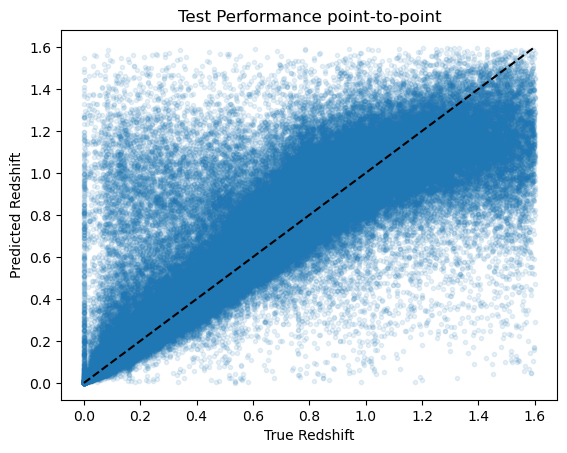

In [64]:
plt.plot(all_z,all_y_hat,'.',alpha=0.1)
plt.title('Test Performance point-to-point')
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.plot([0,args.z_max],[0,args.z_max],'k--')
plt.show()

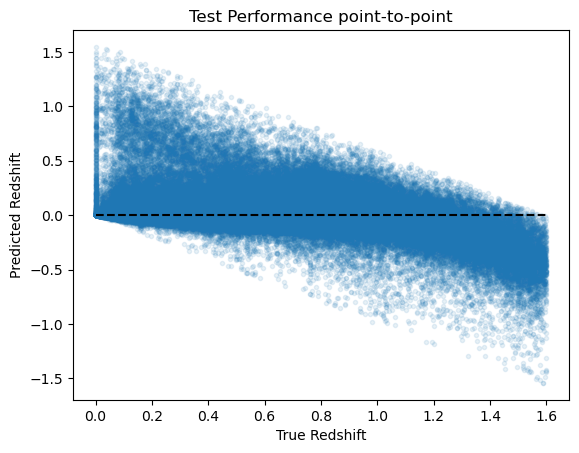

In [65]:
plt.plot(all_z[:],all_y_hat[:]-all_z[:],'.',alpha=0.1)
plt.title('Test Performance point-to-point')
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.plot([0,args.z_max],[0,0.0],'k--')
plt.show()

In [66]:
from calpit.utils import normalize

In [67]:
from mantis_shrimp.utils import cde_loss

In [68]:
residuals_scaled = (all_y_hat - all_z.squeeze())/(1+all_z.squeeze())
#Using Pasquet's definition

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)
#CRPS_ = CRPS(torch.from_numpy(all_cde_hat).cuda(),data_y_val.cuda()).detach().cpu().numpy()

print('My Performance on the Entire Dataset: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')
CDELOSS, CDELOSS_se = cde_loss(normalize(all_cde_hat,np.linspace(0.0,1.6,N_CLASSES)), CLASS_BINS_npy[0:N_CLASSES], data_y_eval)
print('cde_loss: ',np.round(CDELOSS,6),' +/- ',np.round(CDELOSS_se,6))
#print('CRPS: ',np.round(100*CRPS_,6))
print('\n')
print('Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.')

My Performance on the Entire Dataset: 
MAD:  0.024509
BIAS:  0.011562
ETA:  17.608751 % >0.05
cde_loss:  -7.37367  +/-  0.049566


Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.


### Compare to MGS, Beck, WISE-PS1-STRM

how many in MGS mask:  51092
My Performance on MGS: 
MAD:  0.010028
BIAS:  -5.5e-05
ETA:  0.55586 % >0.05
cde_loss:  -25.948753  +/-  0.129377


Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.


decimal percentage of test dataset in MGS:  0.11883214598872895


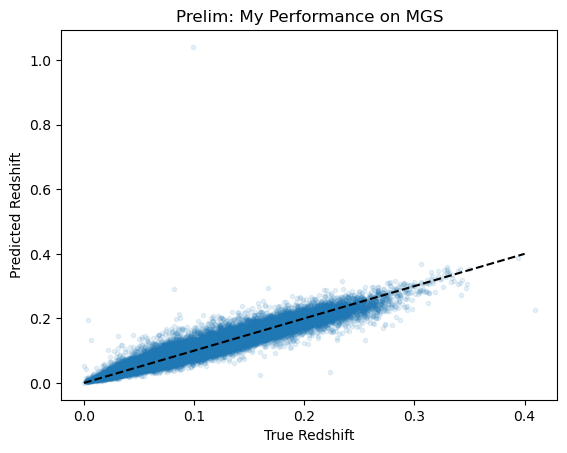

In [69]:
#FIRST get our results using only MGS
residuals_scaled = (all_y_hat - all_z.squeeze())/(1+all_z.squeeze())

MGS_mask = ~np.isnan(photoz_MGS)

print('how many in MGS mask: ',np.sum(MGS_mask))
residuals_scaled = residuals_scaled[MGS_mask]
#Using Pasquet's definition

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)

print('My Performance on MGS: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')
CDELOSS, CDELOSS_se = cde_loss(normalize(all_cde_hat[MGS_mask],np.linspace(0.0,1.6,N_CLASSES)), CLASS_BINS_npy[0:N_CLASSES], data_y_eval[MGS_mask])
print('cde_loss: ',np.round(CDELOSS,6),' +/- ',np.round(CDELOSS_se,6))
print('\n')
print('Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.')
print('\n')
print('decimal percentage of test dataset in MGS: ',np.sum(MGS_mask)/len(MGS_mask))

plt.plot(all_z.squeeze()[MGS_mask],all_y_hat[MGS_mask],'.',alpha=0.1)
plt.title('Prelim: My Performance on MGS')
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.plot([0,0.4],[0,0.4],'k--')
plt.show()

how many in Beck LLR:  51059
Beck Local Linear Regression MGS: 
MAD:  0.013441
BIAS:  0.000767
ETA:  1.359212 % >0.05




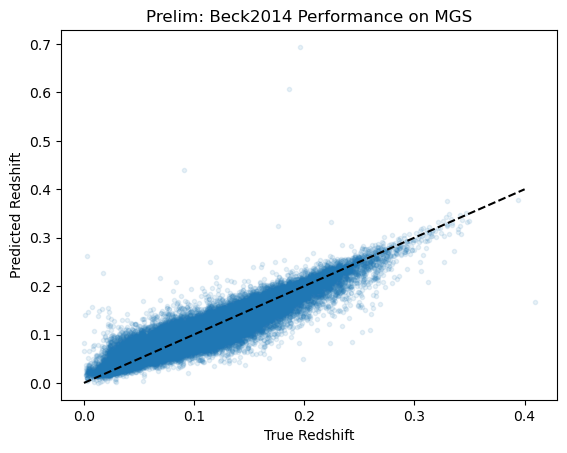

In [70]:
#Next compare to Beck's result on the same MGS sample

residuals_scaled = (photoz_MGS - all_z.squeeze())/(1+all_z.squeeze())
    
residuals_scaled = residuals_scaled[MGS_mask]
mask_residuals = abs(residuals_scaled)<100
residuals_scaled = residuals_scaled[mask_residuals]
#Using Pasquet's definition

print('how many in Beck LLR: ',len(residuals_scaled))
MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)

print('Beck Local Linear Regression MGS: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')
print('\n')


plt.plot(all_z.squeeze()[MGS_mask][mask_residuals],photoz_MGS[MGS_mask][mask_residuals],'.',alpha=0.1)
    
plt.title('Prelim: Beck2014 Performance on MGS')
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.plot([0,0.4],[0,0.4],'k--')
plt.show()

how many in WISE-PS1-STRM mask:  298239
My Performance on WISE-PS1-STRM: 
MAD:  0.018719
BIAS:  0.002996
ETA:  6.605776 % >0.05
cde_loss:  -12.970544  +/-  0.040438


decimal percentage of test dataset in WPS:  0.6936581145293301


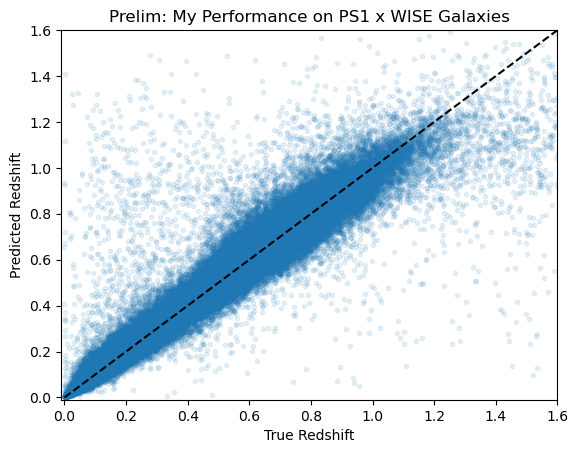

In [71]:
#Next compare to all the available matches in WISE-PS1-STRM
residuals_scaled = (all_y_hat - all_z.squeeze())/(1+all_z.squeeze())


wps_mask = ~np.isnan(photoz_WPS)

print('how many in WISE-PS1-STRM mask: ',np.sum(wps_mask))
residuals_scaled = residuals_scaled[wps_mask]
#Using Pasquet's definition

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)

print('My Performance on WISE-PS1-STRM: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')
CDELOSS, CDELOSS_se = cde_loss(normalize(all_cde_hat[wps_mask],np.linspace(0.0,1.6,N_CLASSES)), CLASS_BINS_npy[0:N_CLASSES], data_y_eval[wps_mask])
print('cde_loss: ',np.round(CDELOSS,6),' +/- ',np.round(CDELOSS_se,6))
print('\n')
print('decimal percentage of test dataset in WPS: ',np.sum(wps_mask)/len(wps_mask))

plt.plot(all_z.squeeze()[wps_mask],all_y_hat[wps_mask],'.',alpha=0.1)
plt.title('Prelim: My Performance on PS1 x WISE Galaxies')
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.plot([0,args.z_max],[0,args.z_max],'k--')
plt.xlim(-0.01,args.z_max)
plt.ylim(-0.01,args.z_max)
plt.show()

how many in WISE-PS1-STRM mask:  298239
Pasquets Defintions: 
MAD:  0.018291
BIAS:  -5.5e-05
ETA:  8.943834 % >0.05


Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.


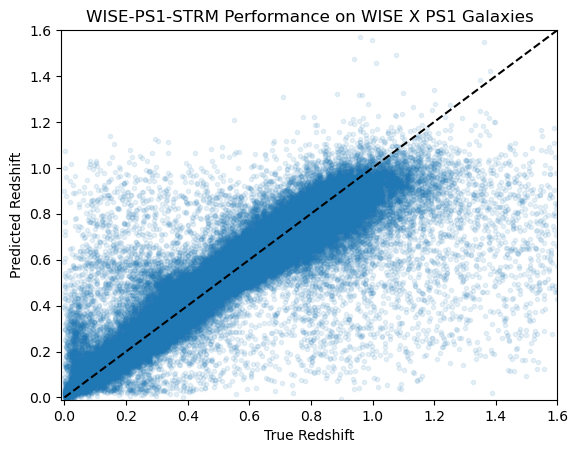

In [72]:
#Next compare to all the available matches in WISE-PS1-STRM


residuals_scaled = (photoz_WPS - all_z.squeeze())/(1+all_z.squeeze())
wps_mask = ~np.isnan(photoz_WPS)


print('how many in WISE-PS1-STRM mask: ',np.sum(wps_mask))
residuals_scaled = residuals_scaled[wps_mask]
#Using Pasquet's definition

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)


print('Pasquets Defintions: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')

print('\n')
print('Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.')


plt.plot(all_z.squeeze()[wps_mask],photoz_WPS[wps_mask],'.',alpha=0.1)
plt.title('WISE-PS1-STRM Performance on WISE X PS1 Galaxies')
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.plot([0,args.z_max],[0,args.z_max],'k--')
plt.xlim(-0.01,args.z_max)
plt.ylim(-0.01,args.z_max)
plt.show()

# More Visualizations


#### point-to-point plot

In [73]:
MAX_Z = args.z_max

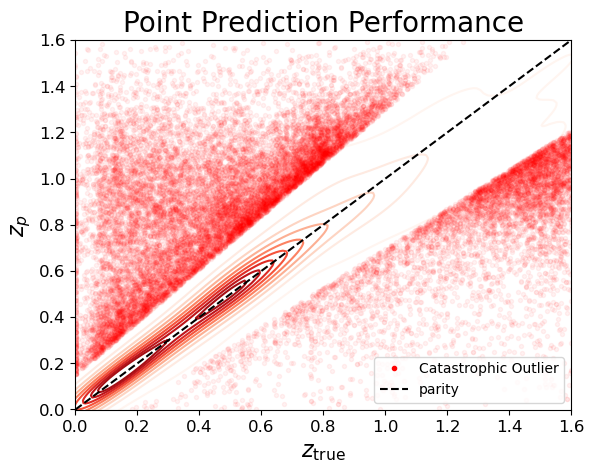

In [74]:
import seaborn as sns

sns.kdeplot(x=all_z[::500],y=all_y_hat[::500],cmap='Reds',)
residual = np.abs(all_z[:] - all_y_hat[:])/(1+all_z[:])
residual_mask = residual > 0.15
plt.plot(all_z[residual_mask],all_y_hat[:][residual_mask],'r.',alpha=0.05,)
plt.plot(-1,-1,'r.',alpha=1.0,label='Catastrophic Outlier')
plt.xlabel(r'$z_{\mathrm{true}}$',fontsize=16)
plt.ylabel(r'$z_{p}$',fontsize=16)
plt.plot([0,MAX_Z],[0,MAX_Z],'k--',label='parity')
plt.xlim(-0.001,MAX_Z)
plt.ylim(-0.001,MAX_Z)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'Point Prediction Performance',fontsize=20)
plt.savefig(f'./../IMAGES/KDE_alloutliers_convnext_early.png',bbox_inches="tight",dpi=600)
plt.legend(loc='lower right')
plt.show()

# Uncertainty

## Overlay credible regions from a random sample

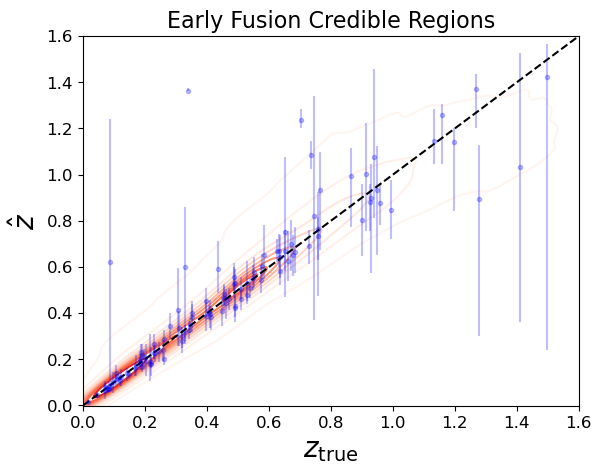

In [75]:
#Calculate uncertainty as [0.05,0.95] confidence regions (90% confidence regions)
##################################
all_cde_hat = all_cde_hat/(np.sum(all_cde_hat,1))[:,None]

residual = np.abs(all_z[:] - all_y_hat)/(1+all_z[:])
residual_mask = residual > 0.0 #in this cell block, just grabbing everything.

#for points with residual mask = True, calculate error bars above and below

cumulative_probability = np.cumsum(all_cde_hat,axis=1)
below_index = np.argmin(abs(cumulative_probability - 0.05),axis=1)
above_index = np.argmin(abs(cumulative_probability - 0.95),axis=1)

value_above = CLASS_BINS[above_index].cpu().numpy()[residual_mask] - all_y_hat[residual_mask]
value_below = all_y_hat[residual_mask] - CLASS_BINS[below_index].cpu().numpy()[residual_mask]

#this deals with point like distributions
value_above[value_above<0] = 0
value_below[value_below<0] = 0
##################################

sns.kdeplot(x=all_z[::10],y=all_y_hat[::10],cmap='Reds',)
plt.errorbar(x=all_z[residual_mask][::4000],y=all_y_hat[residual_mask][::4000],yerr=np.array([value_below,value_above])[:,::4000],fmt='b.',alpha=0.25)
plt.xlabel(r'$z_{\mathrm{true}}$',fontsize=20)
plt.ylabel(r'$\hat{z}$',fontsize=20)
plt.plot([0,MAX_Z],[0,MAX_Z],'k--',label='parity')
plt.xlim(-0.001,MAX_Z)
plt.ylim(-0.001,MAX_Z)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'Early Fusion Credible Regions',fontsize=16)
plt.savefig(f'./../IMAGES/errorbars_randomsample_early_convnext.png',bbox_inches="tight",dpi=600)
plt.show()

### Overlay credible regions from identified ETA catastrophic outliers

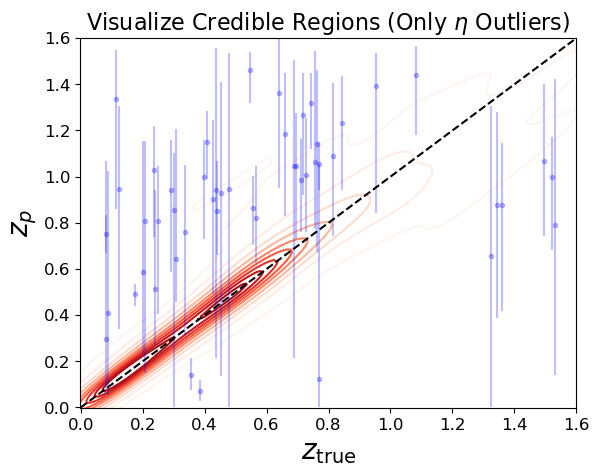

In [38]:
#Calculate uncertainty as [0.05,0.95] confidence regions (90% confidence regions)
##################################
all_cde_hat = all_cde_hat/(np.sum(all_cde_hat,1))[:,None]

residual = np.abs(all_z[:] - all_y_hat)/(1+all_z[:])
residual_mask = residual > 0.15

#for points with residual mask = True, calculate error bars above and below

cumulative_probability = np.cumsum(all_cde_hat,axis=1)
below_index = np.argmin(abs(cumulative_probability - 0.05),axis=1)
above_index = np.argmin(abs(cumulative_probability - 0.95),axis=1)

value_above = CLASS_BINS[above_index].cpu().numpy()[residual_mask] - all_y_hat[residual_mask]
value_below = all_y_hat[residual_mask] - CLASS_BINS[below_index].cpu().numpy()[residual_mask]

#this deals with point like distributions
value_above[value_above<0] = 0
value_below[value_below<0] = 0
##################################

sns.kdeplot(x=all_z[::500],y=all_y_hat[::500],cmap='Reds',)
plt.errorbar(x=all_z[residual_mask][::400],y=all_y_hat[residual_mask][::400],yerr=np.array([value_below,value_above])[:,::400],fmt='b.',alpha=0.25)
plt.xlabel(r'$z_{\mathrm{true}}$',fontsize=20)
plt.ylabel(r'$\hat{z}$',fontsize=20)
plt.plot([0,MAX_Z],[0,MAX_Z],'k--',label='parity')
plt.xlim(-0.001,MAX_Z)
plt.ylim(-0.001,MAX_Z)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'Visualize Credible Regions (Only $\eta$ Outliers)',fontsize=16)
plt.savefig(f'./../IMAGES/errorbars_etaoutliers_early_convnext.png',bbox_inches="tight",dpi=600)
plt.show()

### Overlay credible regions from my definition of catastrophic outliers (>99% region off)

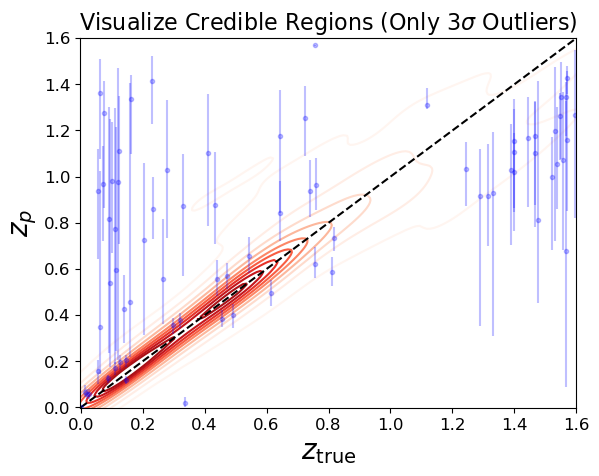

Percentage of >99percent outliers (we expect this to be 1percent): 2.58%


In [39]:
#normalize seems to be changing the array in place.
all_cde_hat = all_cde_hat/(np.sum(all_cde_hat,1))[:,None]

##################################
residual = np.abs(all_z[:] - all_y_hat)/(1+all_z[:])

#for points with residual mask = True, calculate error bars above and below

cumulative_probability = np.cumsum(all_cde_hat,axis=1)
below_index = np.argmin(abs(cumulative_probability - 0.05),axis=1)
above_index = np.argmin(abs(cumulative_probability - 0.95),axis=1)

value_above = CLASS_BINS[above_index].cpu().numpy() - all_y_hat
value_below = all_y_hat - CLASS_BINS[below_index].cpu().numpy()


#this deals with point like distributions
value_above[value_above<0] = 0
value_below[value_below<0] = 0


#FOR THIS, calculate a 99 credible region
below_index2 = np.argmin(abs(cumulative_probability - 0.005),axis=1)
above_index2 = np.argmin(abs(cumulative_probability - 0.995),axis=1)
value_above2 = CLASS_BINS[above_index2].cpu().numpy() - all_y_hat
value_below2 = all_y_hat - CLASS_BINS[below_index2].cpu().numpy()
value_above2[value_above2<0] = 0
value_below2[value_below2<0] = 0

#if true value is no within predicted_value[i]-value_below2[i],predicted_value[i]+value_above[i]
#then the mask is true.
residual_mask = np.logical_or(all_z<all_y_hat-value_below2,all_z>all_y_hat+value_above2)
# for i in range(len(all_z)):
#     if :
        


##################################

sns.kdeplot(x=all_z[::500],y=all_y_hat[::500],cmap='Reds',)
plt.errorbar(x=all_z[residual_mask][::150],y=all_y_hat[residual_mask][::150],
             yerr=np.array([value_below,value_above])[:,residual_mask][:,::150],
             fmt='b.',alpha=0.25,label='90% Credible Regions')
plt.xlabel(r'$z_{\mathrm{true}}$',fontsize=20)
plt.ylabel(r'$\hat{z}$',fontsize=20)
plt.plot([0,MAX_Z],[0,MAX_Z],'k--',label='parity')
plt.xlim(-0.001,MAX_Z)
plt.ylim(-0.001,MAX_Z)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'Visualize Credible Regions (Only 3$\sigma$ Outliers)',fontsize=16)
plt.savefig(f'./../IMAGES/errorbars_myouterliers_late_convnext.png',bbox_inches="tight",dpi=600)
plt.show()

print('Percentage of >99percent outliers (we expect this to be 1percent): {:.2f}%'.format(100*residual_mask.sum()/len(residual_mask)))

#### PIT plot

In [40]:
def PIT(X,Out,title='title',string='plot.png',save=False,n_classes=180,show=True):
    """
    X = spectro Z array
    Out = probabilities array
    """
    X_true_bin = np.argmin(abs(X - np.linspace(0.0,MAX_Z,n_classes+1)[None,:]),axis=1)
    X_true_bin[X_true_bin>=n_classes] = n_classes-1 
    PIT = []

    for i in range(len(X_true_bin)):
        PIT.append(np.sum((Out[i,:])[0:X_true_bin[i]]))

    PIT=np.asarray(PIT)
    
    Pbins=np.linspace(0,1,n_classes+1)
    #draw the line that is if it was a perfect distribution. it would have..
    #len(PIT)/180 #number in each bin
    fig = plt.figure(figsize=(6,5))
    plt.hlines(1.0,0,1,colors='k',linestyles='solid',linewidth=4.0)
    plt.xlim(0-0.02,1+0.02)
    plt.hist(PIT,Pbins,density=True)
    plt.title(title,fontsize=16)
    plt.xlabel('Cumulative Probability Bins',fontsize=18)
    plt.ylabel('Occurences',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #if save==True:
    #plt.savefig(f'./../IMAGES/V1p0_PIT_{args.z_max}_late.png',bbox_inches="tight",dpi=600)
    if show:
        plt.show()
    else:
        return fig

Exception ignored in: <finalize object at 0x2b2e4e250b60; dead>
Traceback (most recent call last):
  File "/people/enge625/.conda/envs/torch2.3_new/lib/python3.11/weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/people/enge625/.conda/envs/torch2.3_new/lib/python3.11/site-packages/numba/core/dispatcher.py", line 267, in finalizer
    for cres in overloads.values():
KeyError: (Array(uint8, 1, 'C', True, aligned=True), Array(uint8, 1, 'C', True, aligned=True))
Exception ignored in: <finalize object at 0x2b2e4e251240; dead>
Traceback (most recent call last):
  File "/people/enge625/.conda/envs/torch2.3_new/lib/python3.11/weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/people/enge625/.conda/envs/torch2.3_new/lib/python3.11/site-packages/numba/core/dispatcher.py", line 267, in fin

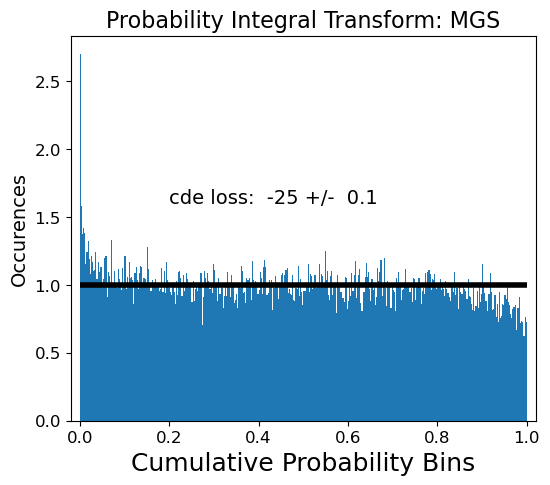

In [49]:
PIT(all_z[:,None][MGS_mask],all_cde_hat[MGS_mask],title=f'Probability Integral Transform: MGS',save=False,n_classes=N_CLASSES,show=False)
plt.text(0.2,1.6,"cde loss:  -25 +/-  0.1",fontsize=14)
plt.savefig('./../IMAGES/V1p4_PIT_late_MGS.png',bbox_inches='tight',dpi=600)
plt.show()

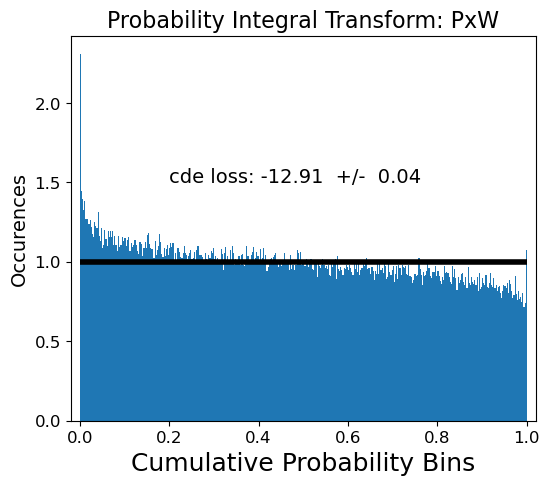

In [50]:
PIT(all_z[:,None][wps_mask],all_cde_hat[wps_mask],title=f'Probability Integral Transform: PxW',save=False,n_classes=N_CLASSES,show=False)
plt.text(0.2,1.5,'cde loss: -12.91  +/-  0.04',fontsize=14)
plt.savefig('./../IMAGES/V1p4_PIT_late_WPS.png',bbox_inches='tight',dpi=600)
plt.show()

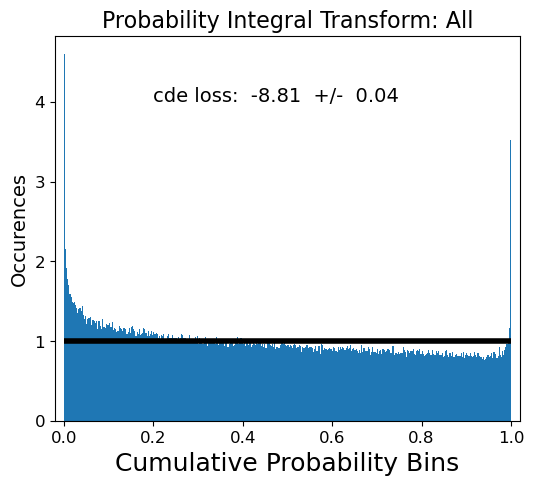

In [41]:
PIT(all_z[:,None],all_cde_hat,title=f'Probability Integral Transform: All',save=False,n_classes=N_CLASSES,show=False)
plt.text(0.2,4,'cde loss:  -8.81  +/-  0.04',fontsize=14)
plt.savefig('./../IMAGES/V1p4_PIT_late_all',bbox_inches='tight',dpi=600)
plt.show()

# Plot the galaxy next to the representation of the model variance over augmentations

In [103]:
MSD = datasets.MantisShrimpDataset(kind=kind_,WORLD_RANK=0,mmap=True,ZMAX=args.z_max,transform=True)

In [104]:
np.random.seed(2)
INDICES = np.random.choice(np.arange(0,len(MSD)),12,replace=False)
model.train(False)
outer_ps = []
for index in INDICES:
    inner_ps = []
    for i in range(20):
        with torch.no_grad():
            x_galex,x_ps,x_unwise,y,ebvs,pz_MGS,pz_WPS = MSD[index]
            
            x_galex = x_galex.cuda()
            x_ps = x_ps.cuda()
            x_unwise = x_unwise.cuda()
            y = y.cuda()
            ebvs = ebvs.cuda()
            
            if LATEFUSION:
                x_galex, x_ps, x_unwise = augment_fn_latefusion(x_galex,x_ps,x_unwise)
            else:
                x_galex, x_ps, x_unwise = augment_fn(x_galex,x_ps,x_unwise)           

            if LATEFUSION:
                y_hat = model(x_galex,x_ps,x_unwise,ebvs)
            else:
                x = torch.concatenate([x_galex,x_ps,x_unwise],1)
                y_hat = model(x,ebvs)

            #x = torch.concat([x_galex,x_ps,x_unwise],dim=1)
            
        
            inner_ps.append(torch.nn.functional.softmax(y_hat,1).cpu().numpy())
    inner_ps = np.array(inner_ps)[:,0,:]
    outer_ps.append(inner_ps)
    
outer_ps = np.stack(outer_ps)

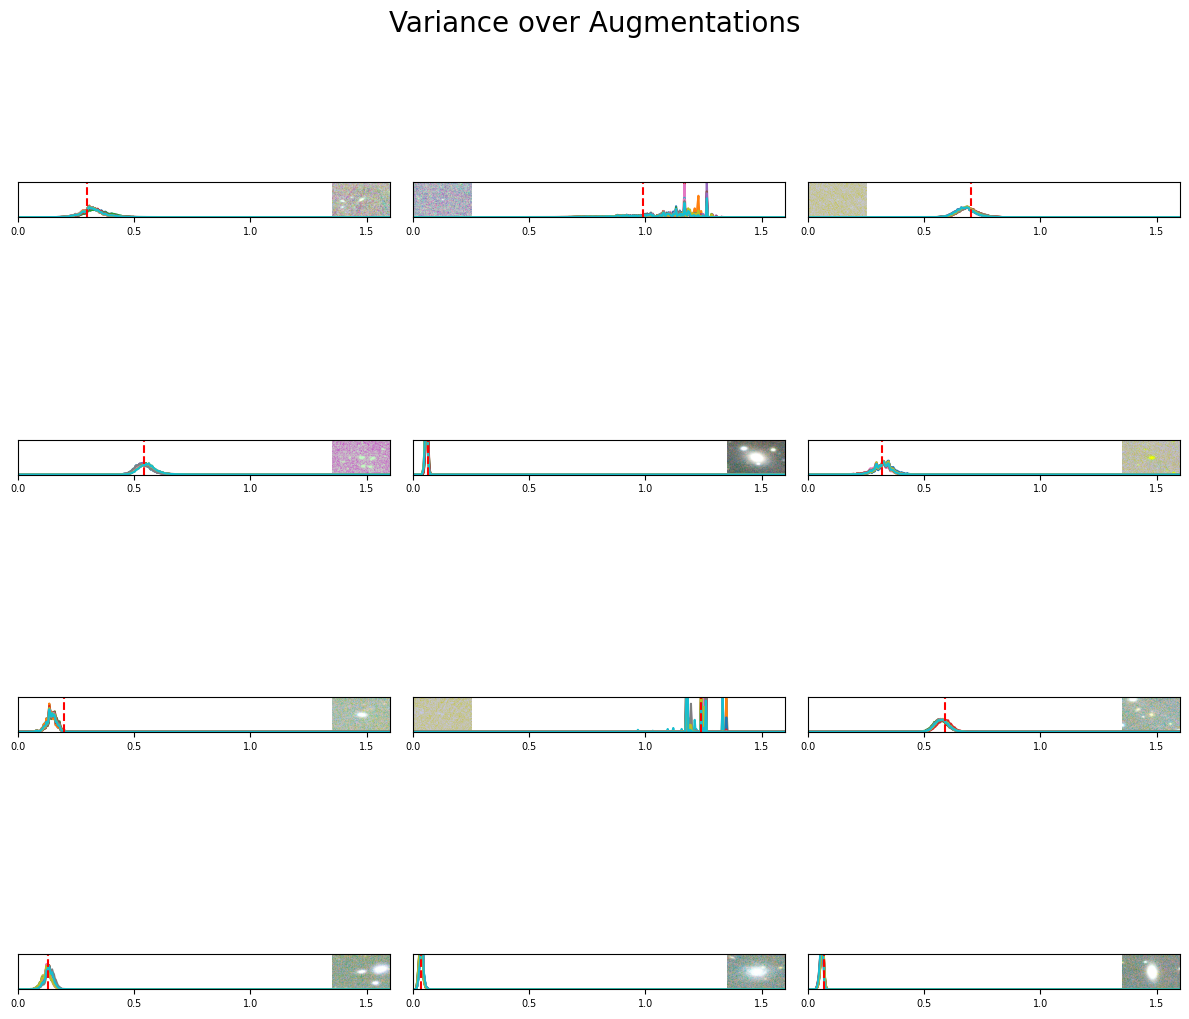

In [113]:

transform = AsinhStretch() + PercentileInterval(90.5)
fig = plt.figure(figsize=(12,12))
for counter,index in enumerate(INDICES):
    plt.subplot(4,3,counter+1)
    for i in range(20):
        plt.plot(CLASS_BINS.cpu().numpy(),outer_ps[counter,i])
    plt.vlines(MSD.z[index],0,0.95,color='red',linestyle='dashed')
    plt.ylim(0,0.15)
    plt.xlim(0,1.6)
    plt.yticks([])
    plt.xticks([0.0,0.5,1.0,1.5],fontsize=7)
    
    img = np.load(get_photopath(MSD._indices[index]),allow_pickle=True).item()
    img_ps = img['panstarrs']
    
    b_ratio = np.mean(img_ps[2])/np.mean(img_ps[0])
    r_ratio = np.mean(img_ps[2])/np.mean(img_ps[4])
    g_ratio = np.mean(img_ps[2])/np.mean(img_ps[2])
    
    rgb_panstarrs = transform(np.array([r_ratio*img_ps[4,], g_ratio*img_ps[2,], b_ratio*img_ps[0,]]))
    rgb_panstarrs = rearrange(rgb_panstarrs,'f h w -> h w f')
    if MSD.z[index] < 0.6:
        plt.imshow(rgb_panstarrs,extent=(1.35,1.6,0.00,0.15))
    else:
        plt.imshow(rgb_panstarrs,extent=(0.00,0.25,0.00,0.15))

plt.tight_layout()
plt.suptitle('Variance over Augmentations',fontsize=20)
plt.show()

<Figure size 600x700 with 0 Axes>

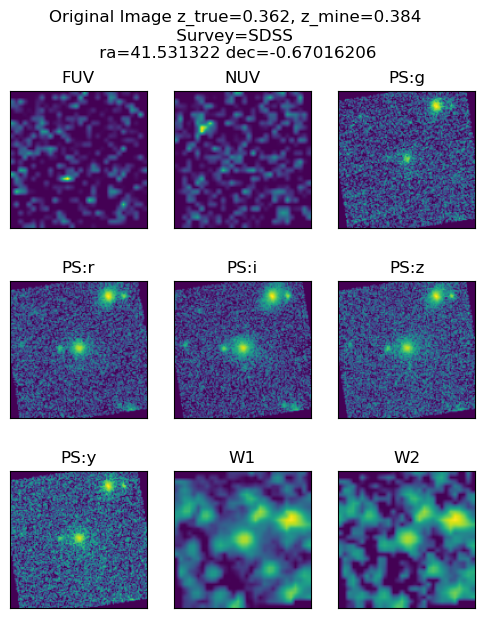

0.3617248 
 SDSS 
 41.531322 
 -0.67016206


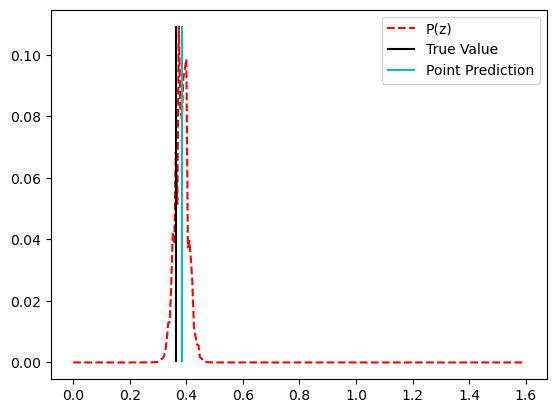

In [75]:
#verify things look right.
from matplotlib import gridspec
fig = plt.figure(figsize=(6, 7))

MSD = datasets.MantisShrimpDataset(kind=kind_,WORLD_RANK=0,mmap=True,ZMAX=args.z_max)
smallDF = MSD.DF.iloc[MSD._indices]
#np.random.seed(1)
#INDICES = np.random.choice(np.arange(0,len(MSD)),12,replace=False)
INDICES = np.where(residual_mask[0:25000])[0]

model.train(False)

#################
#grab a datapoint
#index = INDICES[0]
for index in INDICES:
    fig = plt.figure(figsize=(6, 7))
    with torch.no_grad():
        x_galex,x_ps,x_unwise,y,ebvs,pz_MGS,pz_WPS = MSD[index]

        x_galex = x_galex.cuda()
        x_ps = x_ps.cuda()
        x_unwise = x_unwise.cuda()
        ebvs = ebvs.cuda()
        
        
        if LATEFUSION:
            x_galex, x_ps, x_unwise = augment_fn_latefusion(x_galex,x_ps,x_unwise)
        else:
            x_galex, x_ps, x_unwise = augment_fn(x_galex,x_ps,x_unwise)           

        if LATEFUSION:
            y_hat = model(x_galex,x_ps,x_unwise,ebvs)
        else:
            x = torch.concatenate([x_galex,x_ps,x_unwise],1)
            y_hat = model(x,ebvs)

        y_cde = torch.nn.functional.softmax(y_hat,1)

        point_prediction = torch.sum(CLASS_BINS*y_cde,-1).detach().cpu().numpy()
        y_cde = y_cde.detach().cpu().numpy()


    #################

    FILTERNAMES = ['FUV','NUV','PS:g','PS:r','PS:i','PS:z','PS:y','W1','W2']
    for i in range(9):
        plt.subplot(3,3,i+1)
        if i==0: #switch UV because they are actually stored backwards.
            plt.imshow(x_galex[0,1].detach().cpu().numpy())
        elif i==1:
            plt.imshow(x_galex[0,0].detach().cpu().numpy())
        elif i in [2,3,4,5,6]:
            plt.imshow(x_ps[0,i-2].detach().cpu().numpy())
        elif i in [7,8]:
            plt.imshow(x_unwise[0,i-7].detach().cpu().numpy())
        #plt.imshow(average_over[0,i].detach().cpu().numpy())
        #plt.colorbar()
        plt.xticks([])
        plt.yticks([])
        plt.title(FILTERNAMES[i],fontsize=12)
    plt.suptitle('Original Image z_true={:.3f}, z_mine={:.3f}\n Survey={} \n ra={} dec={}'.format(MSD.z[index],
                                                                                            point_prediction[0],
                                                                                            smallDF.iloc[index].survey,
                                                                                            smallDF.iloc[index].ra,
                                                                                            smallDF.iloc[index].dec,))
    #plt.savefig('./../IMAGES/OGShapImages.png',bbox_inches="tight",dpi=600)
    plt.show()
    
    print(smallDF.iloc[index].z,'\n',
          smallDF.iloc[index].survey,'\n',
          smallDF.iloc[index].ra,'\n',
          smallDF.iloc[index].dec,)
    
    plt.plot(CLASS_BINS.cpu().numpy(),y_cde[0],'r--',label='P(z)')
    plt.vlines(MSD.z[index],np.min(y_cde),np.max(y_cde),'k',label='True Value')
    plt.vlines(point_prediction[0],np.min(y_cde),np.max(y_cde),'c',label='Point Prediction')
    plt.legend()
    plt.show()
    break

# Understand Beck Results


In [45]:
MSD = datasets.MantisShrimpDataset(kind=kind_,WORLD_RANK=0,mmap=True,ZMAX=args.z_max,transform=True)

In [46]:
BECKPZ = MSD.DF['z_phot0'].values
BECKPZ_err = MSD.DF['z_photErr'].values
Redshift = MSD.DF['z'].values

In [47]:
residuals_scaled = (BECKPZ - Redshift)/(1+Redshift)
wps_mask = ~np.isnan(BECKPZ)
wps_mask = np.logical_and(wps_mask,BECKPZ>0)
wps_mask = np.logical_and(wps_mask,BECKPZ<args.z_max)

residuals_scaled = residuals_scaled[wps_mask]
#Using Pasquet's definition

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)


print('Pasquets Defintions: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')
print('\n')
print('Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.')

Pasquets Defintions: 
MAD:  0.018334
BIAS:  -0.00042
ETA:  8.990617 % >0.05


Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.


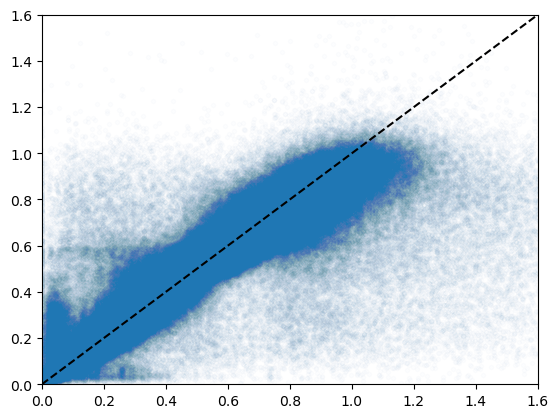

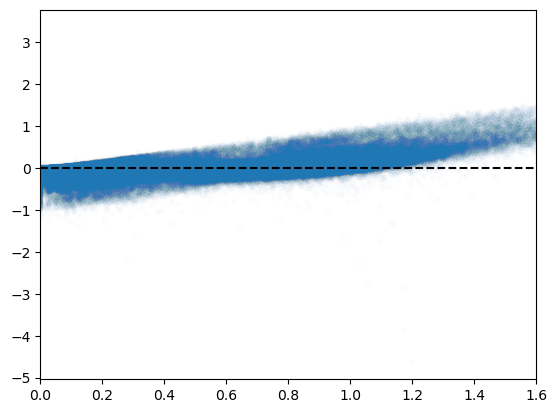

In [48]:
mask = ~np.isnan(BECKPZ)
plt.plot(Redshift[mask],BECKPZ[mask],'.',alpha=0.01)
plt.plot([0,1.6,],[0,1.6],'k--')
plt.xlim(0,1.6)
plt.ylim(0,1.6)
plt.show()

plt.plot(Redshift[mask],Redshift[mask]-BECKPZ[mask],'.',alpha=0.01)
plt.plot([0,1.6,],[0,0.0],'k--')
plt.xlim(0,1.6)
plt.show()

In [49]:
from scipy.stats import norm

In [50]:
BECKPZ = MSD.DF['z_phot0'].values
BECKPZ_err = MSD.DF['z_photErr'].values
Redshift = MSD.DF['z'].values

wps_mask = np.logical_and(~np.isnan(BECKPZ),~np.isnan(BECKPZ_err))
#we will exclude some of Beck's predictions that are outside our interval in order to make sure that our maths works out.
wps_mask = np.logical_and(wps_mask,BECKPZ>0)
wps_mask = np.logical_and(wps_mask,BECKPZ<args.z_max)

print('How many are excluded by my additional cuts: ',np.sum(wps_mask) - np.logical_and(~np.isnan(BECKPZ),~np.isnan(BECKPZ_err)).sum())
##only 2989395 of 4323132. Sure, some of these are stars, but not ALL of them.
CDFs = norm.cdf(x=Redshift[wps_mask],loc=BECKPZ[wps_mask],scale=BECKPZ_err[wps_mask])

#CDEs = norm.pdf(x=CLASS_BINS_npy,loc=BECKPZ[wps_mask],scale=BECKPZ_err[wps_mask])
BECKPZ_err_MINI = np.min(BECKPZ_err[wps_mask][BECKPZ_err[wps_mask] > 0])
BECKPZ_err[np.logical_and(wps_mask,BECKPZ_err==0)] = BECKPZ_err_MINI
CDEs = np.exp(-1*np.square(CLASS_BINS_npy[0:N_CLASSES][None,:] - BECKPZ[wps_mask][:,None]) / 2 / np.square(BECKPZ_err[wps_mask][:,None]))

#this correction turns things that have errors below my bandwidth to a delta function.
for i in np.where(np.sum(CDEs,1)==0)[0]:
    j = np.argmin(np.abs(CLASS_BINS_npy - BECKPZ[wps_mask][i]))
    CDEs[i,j] = 1

#re-normalize
CDEs = CDEs / np.sum(CDEs,1)[:,None]
assert np.allclose(np.sum(CDEs,1),1)

How many are excluded by my additional cuts:  -312


/people/enge625/.conda/envs/torch2.3_new/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2071: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [51]:
CDELOSS, CDELOSS_se = cde_loss(normalize(CDEs,np.linspace(0.0,1.6,400)), CLASS_BINS_npy[0:N_CLASSES], Redshift[wps_mask])
print('cde_loss: ',np.round(CDELOSS,6),' +/- ',np.round(CDELOSS_se,6))

cde_loss:  -10.457757  +/-  0.014875


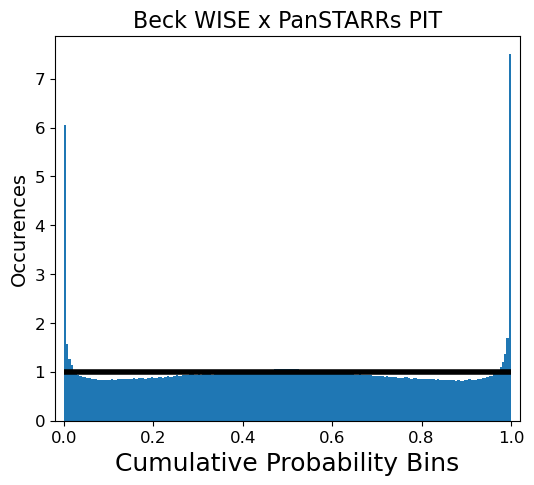

In [53]:
n_classes=200
Pbins=np.linspace(0,1,n_classes+1)
#draw the line that is if it was a perfect distribution. it would have..
#len(PIT)/180 #number in each bin
fig = plt.figure(figsize=(6,5))
plt.hlines(1,0,1,colors='k',linestyles='solid',linewidth=4.0)
plt.xlim(0-0.02,1+0.02)
plt.hist(CDFs,Pbins,density=True)
plt.title('Beck WISE x PanSTARRs PIT',fontsize=16)
plt.xlabel('Cumulative Probability Bins',fontsize=18)
plt.ylabel('Occurences',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#if save==True:
plt.savefig(f'./../IMAGES/BECK_V1p2_PIT.png',bbox_inches="tight",dpi=600)

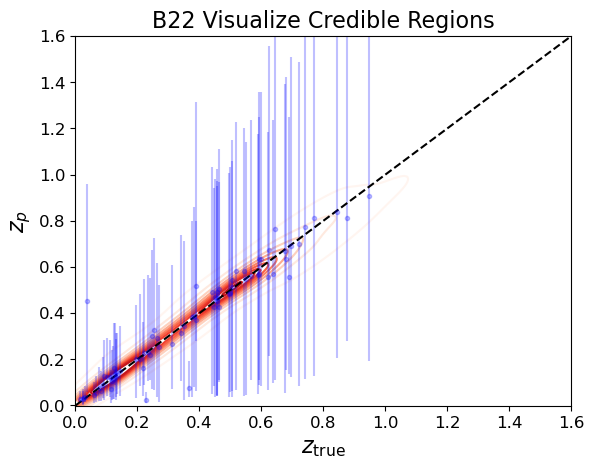

In [83]:
#Calculate uncertainty as [0.05,0.95] confidence regions (90% confidence regions)
##################################
residuals_scaled = (BECKPZ - Redshift)/(1+Redshift)
residual_mask = ~np.isnan(BECKPZ)

#for points with residual mask = True, calculate error bars above and below

value_above = 2*BECKPZ_err[residual_mask] + BECKPZ[residual_mask]
value_below = BECKPZ[residual_mask] - 2*BECKPZ_err[residual_mask]

#this deals with point like distributions
value_above[value_above<0] = 0
value_below[value_below<0] = 0
##################################

sns.kdeplot(x=Redshift[residual_mask][::2000],y=BECKPZ[residual_mask][::2000],cmap='Reds',)
plt.errorbar(x=Redshift[residual_mask][::40000],
             y=BECKPZ[residual_mask][::40000],
             yerr=np.array([value_below,value_above])[:,::40000],
             fmt='b.',alpha=0.25)

plt.xlabel(r'$z_{\mathrm{true}}$',fontsize=16)
plt.ylabel(r'$z_{p}$',fontsize=16)
plt.plot([0,MAX_Z],[0,MAX_Z],'k--',label='parity')
plt.xlim(-0.001,MAX_Z)
plt.ylim(-0.001,MAX_Z)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'B22 Visualize Credible Regions',fontsize=16)
plt.savefig(f'./../IMAGES/V1p0errorbars_Beck_random.png',bbox_inches="tight",dpi=600)
plt.show()

In [90]:
Beck_density_unnormalized = np.array([norm.pdf(CLASS_BINS_npy[0:300],loc=BECKPZ[wps_mask][i],scale=BECKPZ_err[wps_mask][i]) for i in range(1000)])

In [94]:
Beck_density_normalized = Beck_density_unnormalized / np.sum(Beck_density_unnormalized,1)[:,None]

In [97]:
cde_estimates_beck = norm.cdf(x=Redshift[wps_mask],loc=BECKPZ[wps_mask],scale=BECKPZ_err[wps_mask])

Beck_cde_loss_all, Beck_cde_loss_SDEerror = utils.cde_loss(cde_estimates=Beck_density_normalized, z_grid=CLASS_BINS_npy[0:300], z_test=Redshift[wps_mask][0:1000])

NameError: name 'KDTree' is not defined

# Below, More Advanced Analysis We probably don't need.

### Shapley Values

In [25]:
#we need every possible combination of mask.
subset = []
for mask1 in [True,False]:
    for mask2 in [True,False]:
        for mask3 in [True,False]:
            for mask4 in [True,False]:
                for mask5 in [True,False]:
                    for mask6 in [True,False]:
                        for mask7 in [True,False]:
                            for mask8 in [True,False]:
                                for mask9 in [True,False]:
                                    mask_ = np.array([mask1,mask2,mask3,mask4,mask5,mask6,mask7,mask8,mask9])
                                    subset.append(mask_)


#if subset[i,j] is true, then replace j with the baseline of filter j 
subset = torch.from_numpy(np.array(subset))
len(subset) #should be 512

512

In [26]:
#to get more accurate estimate of the background noise, I am going to sample from the edges, with the idea that
#most of my sources are centerd. I'm just avoiding the center.
outer_edges_mask = np.zeros((120,120),dtype=bool)
outer_edges_mask[0:10,:] = True
outer_edges_mask[:,110:120] = True
outer_edges_mask[110:120,:] = True
outer_edges_mask[:,0:10] = True
outer_edges_mask = torch.from_numpy(outer_edges_mask)

In [27]:
from scipy.special import factorial

In [28]:
weights_shap = factorial(subset.numpy().sum(1).astype(int)) * factorial(9 - subset.numpy().sum(1).astype(int) -1) / (factorial(9))
#should be a thing with shape 512.
weights_shap = torch.from_numpy(weights_shap)

In [29]:
kind_ = 'val'
MSD = datasets.MantisShrimpDataset(kind=kind_,WORLD_RANK=0,mmap=False)

In [30]:
from importlib import reload
from mantis_shrimp import extract_magnitude

In [32]:
from torchvision import transforms
augment_ps = transforms.CenterCrop((120,120))
if LATEFUSION:
    augment_unwise = transforms.CenterCrop((32,32))
    augment_galex = transforms.CenterCrop((32,32))
else:
    augment_unwise = transforms.CenterCrop((22,22))
    augment_galex = transforms.CenterCrop((22,22))
upsample = transforms.Resize((120,120),antialias=True)

from mantis_shrimp.utils import galex_transform, new_transform

# Shapley value computation requires big GPU Ram

In [35]:
model.train(False)

#from mantis_shrimp.extract_magnitude import mask_center_source


all_shap = []
all_MMshap = []
all_point_z_shap = []
all_point_z_og = []
correct_redshift = []

kind_ = 'val'

#for world_rank_ in range(16):
    #MSD = datasets.MantisShrimpDataset(kind=kind_,WORLD_RANK=world_rank_,mmap=False)
    
#kind_ = 'val'
#MSD = datasets.MantisShrimpDataset(kind=kind_,WORLD_RANK=0,mmap=False)

counter = 0

with torch.no_grad():
    with tqdm(range(len(MSD))) as tepoch:
        for idx in tepoch:
            
            #were going to need access to the original img vectors.
            img_indices = np.array([MSD.idx_to_imgidx[idx],])
            idx = np.array([idx,])
            img = MSD.img[img_indices]
            if len(img.shape) == 1:
                img = img[None,] #add leading batch dimension

            galex = img[:,0:2048]
            panstarrs = img[:,2048:146548]
            unwise = img[:,146548::]
            
            if np.all(galex[0,0] == 0) or np.all(galex[0,1] == 0):
                continue

            galex = rearrange(galex,'b (f h w) -> b f h w',f=2,h=32,w=32)
            panstarrs = rearrange(panstarrs,'b (f h w) -> b f h w',f=5,h=170,w=170)
            unwise = rearrange(unwise,'b (f h w) -> b f h w',f=2,h=32,w=32)

            #these Nones will add a leading batch dimension.
            z = MSD.z[idx][None,]
            ebv_csfd = MSD.ebv_csfd[idx][None,]
            ebv_planck = MSD.ebv_planck[idx][None,]
            
            #form the extinction vector.
            ebvs = np.concatenate([ebv_csfd,ebv_planck]).T
            
            #this transforms the galex, panstarrs, and unwise arrays into the scheme used as input...
            #but for this we will also need to retain the original arrays for x_prime.
            #i.e., galex is in linear flux scale, x_galex has been processed for a NN input.
            x_galex = galex_transform(galex,0.05)
            x_ps =  new_transform(panstarrs,0.01,8.0)
            x_unwise = new_transform(unwise,0.1,6.0)

            #fill NaNs.
            x_ps[np.isnan(x_ps)] = 0.0
            panstarrs[np.isnan(panstarrs)] = 0.0
            
            #now place these into tensors.
            x_galex = torch.from_numpy(x_galex)
            x_ps = torch.from_numpy(x_ps)
            x_unwise = torch.from_numpy(x_unwise)
            ebv = torch.from_numpy(ebvs)

            #and place the tensors onto the GPU.
            x_galex = x_galex.cuda()
            x_ps =  x_ps.cuda()
            x_unwise = x_unwise.cuda()
            ebv = ebv.cuda()
            
            ####
            #now we create the x_prime baseline image. We will need 3 numpy arrays to represent
            #the data, and a final torch array we can plage augmentations into.
            x_prime_galex = np.zeros_like(galex)
            x_prime_ps = np.zeros_like(panstarrs)
            x_prime_unwise = np.zeros_like(unwise)
            #this part is neccessary because I switch, then switch, the filters, because I switched them...
            #more serriously, mask_center_source does a correction, but I perform the same correction below
            for filter_ in range(9):

                masked_img = extract_magnitude.mask_center_source(galex[0],
                                                                  panstarrs[0],
                                                                  unwise[0],
                                                                  filter_)
                if filter_ in [0,1]:
                    x_prime_galex[0,filter_,:,:] = masked_img
                if filter_ in [2,3,4,5,6]:
                    x_prime_ps[0,filter_-2,:,:] = masked_img
                if filter_ in [7,8]:
                    x_prime_unwise[0,filter_-7,:,:] = masked_img
                
            #now transform my stuff.
            x_prime_galex = galex_transform(x_prime_galex,0.05)
            x_prime_ps =  new_transform(x_prime_ps,0.01,8.0)
            x_prime_unwise = new_transform(x_prime_unwise,0.1,6.0)
            
            #make into torch tensors.
            x_prime_galex = torch.from_numpy(x_prime_galex).cuda()
            x_prime_ps = torch.from_numpy(x_prime_ps).cuda()
            x_prime_unwise = torch.from_numpy(x_prime_unwise).cuda()
            
            #now do some minimal augmentations.
            x_prime_galex = augment_galex(x_prime_galex)
            x_galex = augment_galex(x_galex)
            
            x_prime_ps = augment_ps(x_prime_ps)
            x_ps = augment_ps(x_ps)
            
            x_prime_unwise = augment_unwise(x_prime_unwise)
            x_unwise = augment_unwise(x_unwise)
            
            if LATEFUSION:
                pass
            else:
                x_galex = upsample(x_galex)
                x_prime_galex = upsample(x_prime_galex)

                x_unwise = upsample(x_unwise)
                x_prime_unwise = upsample(x_prime_unwise)

            #finalize image
            #
            #x_prime = torch.concatenate([x_prime_galex, x_prime_ps, x_prime_unwise],1)
            
            
            
            #now with this defined I need to make the length 512 sample of all possible combinations of image.
            #these are just containers of the right size that I will fill up in the next for loop.
            x_prime_galex_real = x_galex.repeat(512,1,1,1)
            x_prime_ps_real = x_ps.repeat(512,1,1,1)
            x_prime_unwise_real = x_unwise.repeat(512,1,1,1)
            ebv = ebv.repeat(512,1)


            
            #here I fill in x_prime all with samples from subset to make a 512 batchsize tensor.
            for i in range(512):               
                x_prime_galex_real[i,subset[i][0:2],] = x_prime_galex[0,subset[i][0:2]]
                x_prime_ps_real[i,subset[i][2:7],] = x_prime_ps[0,subset[i][2:7]]
                x_prime_unwise_real[i,subset[i][7:9],] = x_prime_unwise[0,subset[i][7:9]]
            
            if not(LATEFUSION):
                x_prime_all = torch.cat([x_prime_galex_real,x_prime_ps_real,x_prime_unwise_real],1)
                x = torch.concatenate([x_galex, x_ps, x_unwise],1)
                
            if LATEFUSION:               
                y_hat = model(x_prime_galex_real,x_prime_ps_real,x_prime_unwise_real,ebv)
                y_hat_og = model(x_galex,x_ps,x_unwise,ebv[0:1,:])
            else:
            #now run x_prime_all through the model:
                y_hat = model(x_prime_all,ebv)
                y_hat_og = model(x,ebv[0:1,:])

            
            assert torch.isnan(y_hat).any() == False
            assert torch.isnan(y_hat_og).any() == False
            #calculate the point estimate. point_z is val()
            point_z = torch.sum(CLASS_BINS * torch.nn.functional.softmax(y_hat,dim=-1),-1)
            point_z_og = torch.sum(CLASS_BINS * torch.nn.functional.softmax(y_hat_og,dim=-1),-1)
            
            all_point_z_shap.append(point_z) #should be a 512,1 array... 
            all_point_z_og.append(point_z_og.flatten().item())

            #correct_redshift.append(y.item())#just in case we use it.
            #break
            counter+=1
            #if counter == 5:
            #    raise Exception
            
        

 39%|███████████████████████████████████████████████████████████▊                                                                                             | 9768/24971 [1:52:52<3:09:21,  1.34it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 22811/24971 [4:23:51<26:58,  1.33it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
Server

In [36]:
all_point_z_shap = torch.concat(all_point_z_shap)
all_point_z_og = torch.tensor(all_point_z_og)

In [37]:
#all_point_z_shap = all_point_z_shap.reshape(len(MSD),512)
all_point_z_shap = all_point_z_shap.reshape(counter,512)

In [38]:
shapley_values = []
weights_shap = weights_shap.cuda()
subset = subset.cuda()
with torch.no_grad():
    for i in tqdm(range(len(all_point_z_shap))):
        filters_shap = []
        point_z = all_point_z_shap[i]
        for j in range(9):
            #this should be a 512/2 thing * a (512/2 - 512/2) thing, reduced to a 1 thing via the sum.
            #the sign is important here, REMEMBER: if the mask subset is true, then I REPLACE with the baseline image.
            #so subset=True should be equivalent to S., Subset==False. But its not just the shapes it also needs to be the patterns.
            
            shap_j = torch.sum(weights_shap[subset[:,j]==True] * (point_z[subset[:,j]==False] - point_z[subset[:,j]==True]))
            filters_shap.append(shap_j.item())
        shapley_values.append(torch.tensor(filters_shap))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23085/23085 [00:59<00:00, 385.19it/s]


In [39]:
shapley_values = torch.stack(shapley_values).cpu().numpy()

In [40]:
mm_shap_values = abs(shapley_values) / np.sum(abs(shapley_values),1)[:,None] 

In [41]:
# np.save('./7_9_24all_shap_np_test_nozeros_late_rank0.npy',shapley_values)
# np.save('./7_9_24_MMshap_np_test_nozeros_late_rank0.npy',mm_shap_values)
# np.save('./7_9_24_all_point_z_og_rank0.npy',all_point_z_og.cpu().numpy())

In [42]:
all_shap_np = np.load('./7_9_24all_shap_np_test_nozeros_late_rank0.npy')
all_MMshap_np = np.load('./7_9_24_MMshap_np_test_nozeros_late_rank0.npy')
all_y_hat = np.load('./7_9_24_all_point_z_og_rank0.npy')

#all_shap_np = np.load('./4_22_24all_shap_np_test_nozeros.npy')
#all_MMshap_np = np.load('./4_22_24_MMshap_np_test_nozeros.npy')

#all_shap_np = np.load('./4_22_24all_shap_np_test.npy')
#all_MMshap_np = np.load('./4_22_24_MMshap_np_test.npy')

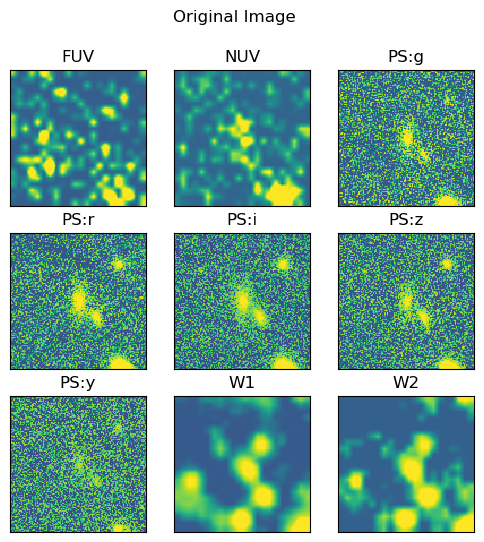

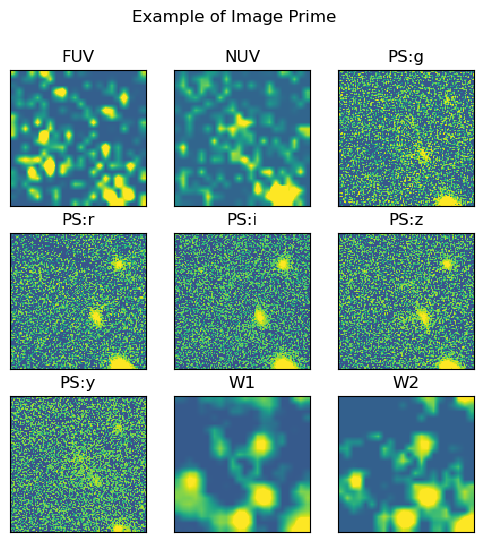

In [61]:
#verify things look right.
from matplotlib import gridspec
fig = plt.figure(figsize=(6, 6))

FILTERNAMES = ['FUV','NUV','PS:g','PS:r','PS:i','PS:z','PS:y','W1','W2']

for i in range(9):
    plt.subplot(3,3,i+1)
    if i==0: #switch UV because they are actually stored backwards.
        m, s = torch.mean(x_galex[0,1]).item(), torch.std(x_galex[0,1]).item()
        plt.imshow(x_galex[0,1].detach().cpu().numpy(),interpolation='nearest',vmin=m-2*s,vmax=m+2*s)
    elif i==1:
        m, s = torch.mean(x_galex[0,0]).item(), torch.std(x_galex[0,0]).item()
        plt.imshow(x_galex[0,0].detach().cpu().numpy(),interpolation='nearest',vmin=m-2*s,vmax=m+2*s)
    elif i in [2,3,4,5,6]:
        m, s = torch.mean(x_ps[0,i-2]).item(), torch.std(x_ps[0,i-2]).item()
        plt.imshow(x_ps[0,i-2].detach().cpu().numpy(),interpolation='nearest',vmin=m-2*s,vmax=m+2*s)
    elif i in [7,8]:
        m, s = torch.mean(x_unwise[0,i-7]).item(), torch.std(x_unwise[0,i-7]).item()
        plt.imshow(x_unwise[0,i-7].detach().cpu().numpy(),interpolation='nearest',vmin=m-2*s,vmax=m+2*s)
    #plt.imshow(average_over[0,i].detach().cpu().numpy())
    #plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.title(FILTERNAMES[i],fontsize=12)
plt.suptitle('Original Image')
plt.savefig('./../IMAGES/OGShapImages_nozeros_late.png',bbox_inches="tight",dpi=600)
plt.show()

fig = plt.figure(figsize=(6, 6))

subset_index = 0
for i in range(9):
    plt.subplot(3,3,i+1)
    if i==0: #because galex is switched around
        m, s = torch.mean(x_galex[0,1]).item(), torch.std(x_galex[0,1]).item()
        plt.imshow(x_prime_galex_real[subset_index,1].detach().cpu().numpy(),interpolation='nearest',vmin=m-2*s,vmax=m+2*s)
    elif i==1:
        m, s = torch.mean(x_galex[0,0]).item(), torch.std(x_galex[0,0]).item()
        plt.imshow(x_prime_galex_real[subset_index,0].detach().cpu().numpy(),interpolation='nearest',vmin=m-2*s,vmax=m+2*s)
    elif i in [2,3,4,5,6]:
        m, s = torch.mean(x_ps[0,i-2]).item(), torch.std(x_ps[0,i-2]).item()
        plt.imshow(x_prime_ps_real[subset_index,i-2].detach().cpu().numpy(),interpolation='nearest',vmin=m-2*s,vmax=m+2*s)
    elif i in [7,8]:
        m, s = torch.mean(x_unwise[0,i-7]).item(), torch.std(x_unwise[0,i-7]).item()
        plt.imshow(x_prime_unwise_real[subset_index,i-7].detach().cpu().numpy(),interpolation='nearest',vmin=m-2*s,vmax=m+2*s)
    #plt.imshow(average_over[0,i].detach().cpu().numpy())
    #plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.title(FILTERNAMES[i],fontsize=12)
plt.suptitle('Example of Image Prime')
plt.savefig('./../IMAGES/BaselineShapImages_nozeros_late.png',bbox_inches="tight",dpi=600)
plt.show()

In [43]:
colorlist2 = ['#7048e8', '#4263eb', '#228be6', '#40c057', '#fab005', '#fd7e14', '#e03131','xkcd:coffee','k']

In [63]:
#all_y_hat = all_point_z_og.cpu().numpy()

In [44]:
mostly_forced_guesses_redshift = np.array([0.21,0.645,0.485,0.77,0.96,0.85,0.72,1.0,1.0])

In [45]:
###Now using these values, plot the shapley values for each band across true redshift
from matplotlib import colormaps
cmap =  colormaps.get_cmap('jet')
FILTERNAMES = ['GALEX:FUV','GALEX:NUV','PS:g','PS:r','PS:i','PS:z','PS:y','WISE:W1','WISE:W2']

colorlist = ['xkcd:grey',
             'xkcd:violet',
             'xkcd:lightblue',
             'xkcd:blue',
             'xkcd:green',
             'xkcd:orange',
             'xkcd:red',
             'xkcd:olive',
             'xkcd:black']
N_BOOTSTRAPS = 1000
CLASS_BINS2 = np.linspace(0.0,1.4,75) #lower the amount of bins for now. 
CLASS_BINS2_centers = CLASS_BINS2[0:-1] + (CLASS_BINS2[1::] - CLASS_BINS2[0:-1])/2
plots = np.zeros((len(CLASS_BINS2_centers),9))
upper_limits = np.zeros((len(CLASS_BINS2_centers),9))
lower_limits = np.zeros((len(CLASS_BINS2_centers),9))
for j in range(len(CLASS_BINS2)-1):
    mask = np.logical_and(all_y_hat>=CLASS_BINS2[j],all_y_hat<CLASS_BINS2[j+1])
    mask = mask[0:len(all_MMshap_np)]
    for i in range(9):
        if i==0:
            plots[j,i] = np.mean(all_MMshap_np[mask,1])
            #now use bootstrapping technique to draw re-samples with replacement.
            means = []
            for bootstrap in range(N_BOOTSTRAPS):
                means.append(np.mean(np.random.choice(all_MMshap_np[mask,1],len(all_MMshap_np[mask,1]),True)))
            upper_limits[j,i] = plots[j,i] - np.quantile(means,0.05)
            lower_limits[j,i] = np.quantile(means,0.95) - plots[j,i]
        elif i==1:
            plots[j,i] = np.mean(all_MMshap_np[mask,0])
            #now use bootstrapping technique to draw re-samples with replacement.
            means = []
            for bootstrap in range(N_BOOTSTRAPS):
                means.append(np.mean(np.random.choice(all_MMshap_np[mask,0],len(all_MMshap_np[mask,0]),True)))
            upper_limits[j,i] = plots[j,i] - np.quantile(means,0.05)
            lower_limits[j,i] = np.quantile(means,0.95) - plots[j,i]
        else:
            plots[j,i] = np.mean(all_MMshap_np[mask,i])
            #now use bootstrapping technique to draw re-samples with replacement.
            means = []
            for bootstrap in range(N_BOOTSTRAPS):
                means.append(np.mean(np.random.choice(all_MMshap_np[mask,i],len(all_MMshap_np[mask,i]),True)))
            upper_limits[j,i] = plots[j,i] - np.quantile(means,0.05)
            lower_limits[j,i] = np.quantile(means,0.95) - plots[j,i]
        


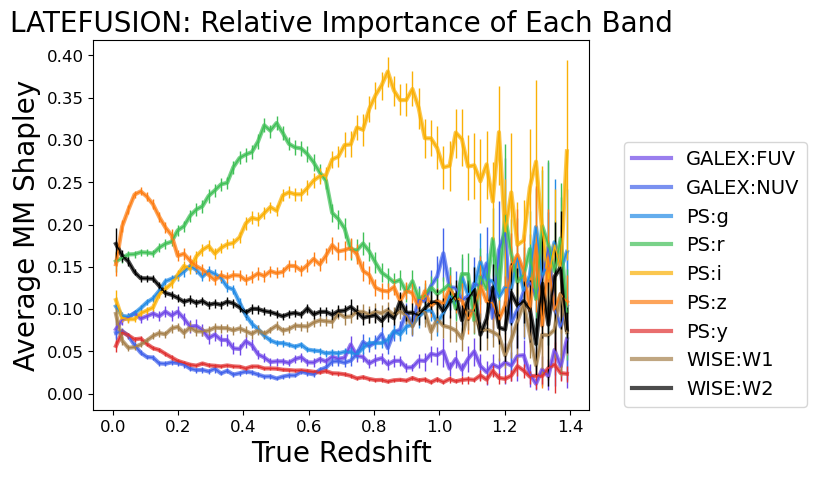

In [50]:
for i in range(9):
    plt.plot(CLASS_BINS2_centers,plots[:,i],c=colorlist2[i],label=FILTERNAMES[i],linewidth=3,alpha=0.7)
    plt.errorbar(CLASS_BINS2_centers,
                 plots[:,i],
                 yerr=(lower_limits[:,i],
                       upper_limits[:,i]),
                 c=colorlist2[i],
                 linewidth=1.0,
                 alpha=1.0)
    
plt.legend(bbox_to_anchor=(1.05,0.75),fontsize=14)
plt.ylabel('Average MM Shapley',fontsize=20)
plt.xlabel('True Redshift',fontsize=20)
plt.title('LATEFUSION: Relative Importance of Each Band',fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('./../IMAGES/MMShapleyValues_nozeros_late_rank0.png',bbox_inches="tight",dpi=600)
plt.show()

In [47]:
###Now using these values, plot the shapley values for each band across true redshift
from matplotlib import colormaps
cmap =  colormaps.get_cmap('jet')


CLASS_BINS2 = np.linspace(0.0,1.4,75) #lower the amount of bins for now. 
CLASS_BINS2_centers = CLASS_BINS2[0:-1] + (CLASS_BINS2[1::] - CLASS_BINS2[0:-1])/2
plots_shap = np.zeros((len(CLASS_BINS2_centers),9))
upper_limits_shap =  np.zeros((len(CLASS_BINS2_centers),9))
lower_limits_shap =  np.zeros((len(CLASS_BINS2_centers),9))

for j in range(len(CLASS_BINS2)-1):
    mask = np.logical_and(all_y_hat>=CLASS_BINS2[j],all_y_hat<CLASS_BINS2[j+1])
    mask = mask[0:len(all_shap_np)]
    for i in range(9):
        
        if i==0:
            plots_shap[j,i] = np.mean(all_shap_np[mask,1])
            means = []
            for bootstrap in range(N_BOOTSTRAPS):
                means.append(np.mean(np.random.choice(all_shap_np[mask,1],len(all_shap_np[mask,1]),True)))
                
            upper_limits_shap[j,i] = plots_shap[j,i] - np.quantile(means,0.05)
            lower_limits_shap[j,i] = np.quantile(means,0.95) - plots_shap[j,i]
        elif i==1:
            plots_shap[j,i] = np.mean(all_shap_np[mask,0])
            means = []
            for bootstrap in range(N_BOOTSTRAPS):
                means.append(np.mean(np.random.choice(all_shap_np[mask,0],len(all_shap_np[mask,0]),True)))
                
            upper_limits_shap[j,i] = plots_shap[j,i] - np.quantile(means,0.05)
            lower_limits_shap[j,i] = np.quantile(means,0.95) - plots_shap[j,i]
        else:
            plots_shap[j,i] = np.mean(all_shap_np[mask,i])
            means = []
            for bootstrap in range(N_BOOTSTRAPS):
                means.append(np.mean(np.random.choice(all_shap_np[mask,i],len(all_shap_np[mask,i]),True)))
                
            upper_limits_shap[j,i] = plots_shap[j,i] - np.quantile(means,0.05)
            lower_limits_shap[j,i] = np.quantile(means,0.95) - plots_shap[j,i]



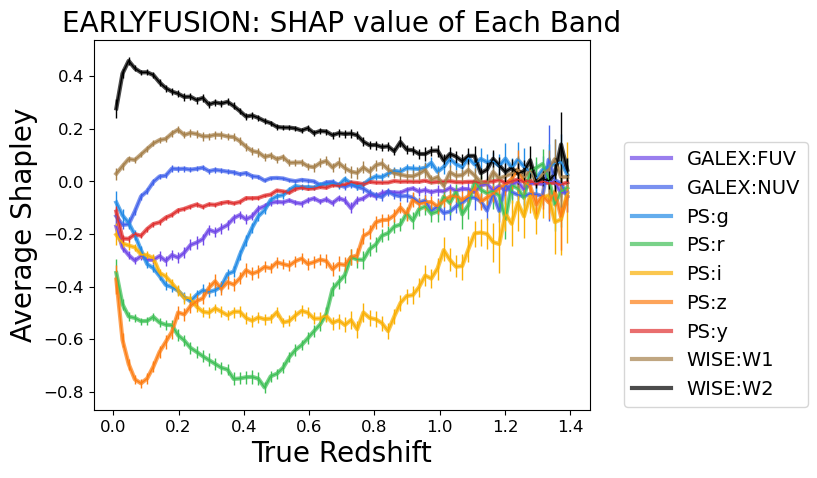

In [48]:
for i in range(9):
    plt.plot(CLASS_BINS2_centers,plots_shap[:,i],c=colorlist2[i],label=FILTERNAMES[i],linewidth=3,alpha=0.7)
    plt.errorbar(CLASS_BINS2_centers,
             plots_shap[:,i],
             yerr=(lower_limits_shap[:,i],
                   upper_limits_shap[:,i]),
             c=colorlist2[i],
             linewidth=1.0,
             alpha=1.0)
    
plt.legend(bbox_to_anchor=(1.05,0.75),fontsize=14)
plt.ylabel('Average Shapley',fontsize=20)
plt.xlabel('True Redshift',fontsize=20)
plt.title('EARLYFUSION: SHAP value of Each Band',fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('./../IMAGES/ShapleyValues_nozeros_late_rank0.png',bbox_inches="tight",dpi=600)
plt.show()